# Negative binomial models with dispersion estimates

`delnx` implements a negative binomial model as well as size factor and dispersion estimation for differential expression analysis. This is heavily inspired by [DESeq2](https://bioconductor.org/packages/release/bioc/html/DESeq2.html) / [PyDESeq2](https://pydeseq2.readthedocs.io/en/stable/). While it's not an exact reimplementation of these methods, it achieves very similar results and is a lot quicker (especially on GPUs), thanks to [JAX](https://jax.readthedocs.io/en/latest/). Here's a quick example of the basic workflow:

In [31]:
import delnx as dx
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt

# Load example data
adata = sc.read_h5ad("data/GLI3_KO_45d_pseudobulk.h5ad")

# Use DESeq2-style median-of-ratios to compute size factors
dx.pp.size_factors(adata, method="ratio")

# Estimate dispersion using a DESeq2-inspired method
dx.pp.dispersion(adata, size_factor_key="size_factors", covariate_keys=["GLI3_KO"])

print(adata)

INFO     Fitting initial dispersions                                                                               


100%|██████████| 8/8 [00:03<00:00,  2.58it/s]

INFO     Fitting dispersion trend curve                                                                            


INFO     Fitting MAP dispersions                                                                                   


100%|██████████| 8/8 [00:00<00:00, 27.81it/s]

AnnData object with n_obs × n_vars = 28 × 16199
    obs: 'psbulk_replicate', 'cell_type', 'organoid', 'GLI3_KO', 'psbulk_cells', 'psbulk_counts', 'size_factor', 'size_factors'
    var: 'dispersion', 'dispersion_deseq', 'dispersion_mle', 'dispersion_edger', 'mean', 'mean_norm', 'dispersions', 'dispersions_init', 'dispersions_trend', 'dispersions_map', 'dispersions_mle', 'mle_converged'
    uns: 'log1p'
    layers: 'counts', 'lognorm', 'psbulk_props'


Now we have size factors for each cell and dispersion estimates for each gene stored in `adata.obs['size_factors']` and `adata.var['dispersions']`, respectively. As a quick check, we also estimate dispersion using `PyDESeq2` and compare the results

In [33]:
adata.var["delnx_dispersions"] = adata.var["dispersions"].copy()

In [ ]:
from pydeseq2.dds import DefaultInference, DeseqDataSet

inference = DefaultInference()
dds_icpt = DeseqDataSet(
    adata=adata,
    design="~ GLI3_KO",
    inference=inference,
)
dds_icpt.deseq2()

Fitting size factors...
... done in 0.02 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 12.29 seconds.

Fitting dispersion trend curve...
... done in 0.32 seconds.

Fitting MAP dispersions...
... done in 16.25 seconds.

Fitting LFCs...
... done in 8.11 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 127 outlier genes.

Fitting dispersions...
... done in 0.12 seconds.

Fitting MAP dispersions...
... done in 0.15 seconds.

Fitting LFCs...
... done in 0.10 seconds.



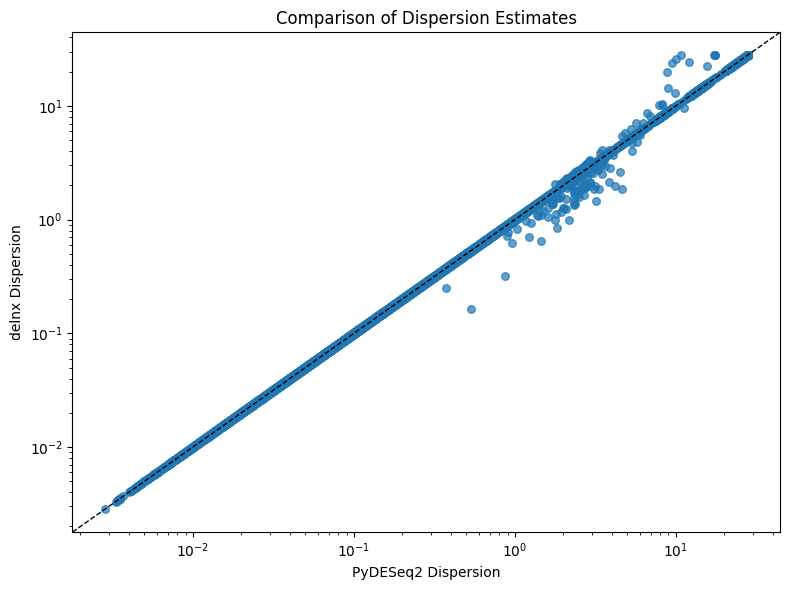

In [28]:
plt.figure(figsize=(8, 6))
plt.scatter(
    dds_icpt.var["MAP_dispersions"],
    dds_icpt.var["delnx_dispersions"],
    s=30,
    alpha=0.7,
)
plt.axline((0, 0), slope=1, color="black", linestyle="--", linewidth=1, label="y=x")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("PyDESeq2 Dispersion")
plt.ylabel("delnx Dispersion")
plt.title("Comparison of Dispersion Estimates")
plt.tight_layout()
plt.show()
plt.close()

While not exactly the same, we can see that the dispersion estimates from delnx are very similar to the ones from DESeq2. Now, we can use these dispersion estimates to perform differential expression analysis with a negative binomial model.

In [ ]:
# Run differential expression analysis with negative binomial model
de_results = dx.tl.de(
    adata,
    method="negbinom",  # Use negative binomial model for DE analysis
    condition_key="GLI3_KO",  # Key for condition variable
    size_factor_key="size_factors",  # Key for size factors
    dispersion_key="delnx_dispersions",  # Key for dispersion estimates
)

INFO     Inferred data type: counts                                                                                
INFO     Testing False vs True                                                                                     
INFO     Running DE for 16134 features                                                                             


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


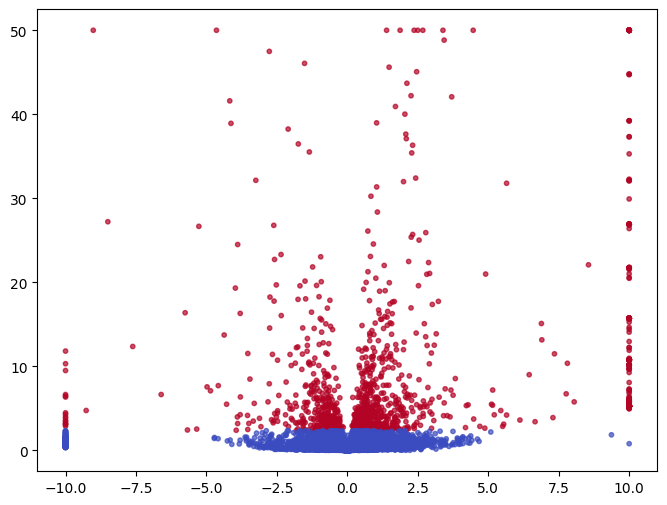

In [47]:
# Vulcano plot
plt.figure(figsize=(8, 6))
plt.scatter(
    de_results["log2fc"],
    -np.log10(de_results["pval"]),
    c=de_results["padj"] < 0.05,
    cmap="coolwarm",
    s=10,
    alpha=0.7,
)